# XGBoost 분류 SklearnWrapper

XGBoost 라이브러리를 sklearn과의 호환을 위해 Wrappering한 클래스

DMatrix가 아닌 표준 DataFrame을 사용할 수 있다.

## #01. 기본 준비

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# xgboost
# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, to_graphviz

### [2] 데이터 가져오기 + 기본 데이터 처리

In [2]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)

# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

((614, 8), (154, 8), (614,), (154,))

## #02. XGBoost 학습 모델 적합

몇몇 하이퍼파라미터의 이름이 변경된다.

| XGBoost 기본 | Sklearn Wrapper |
|---|---|
| eta | learing_rate |
| num_boost_round |  n_estimator |
| sub_sample | subsample |
| lambda | reg_lambda |
| alpha | reg_alpha |
| nthread | n_jobs |

### [1] 주요 하이퍼 파라미터

XGBoost의 파라미터는 크게 세가지 종류로 구분된다.

| 구분 | 설명 |
|---|---|
| General Parameter | 시스템 관련 설정. 기본값을 거의 변경할 일이 없기 때문에 대체로 명시하지 않는 경우가 많다. |
| Train Parameter | 학습에 활용되는 객체 함수. 모형의 평가를 위한 지표 등을 설정한다. |
| Booster Parameter (매우 중요) | 모형 성능에 영향을 미치는 하이퍼파라미터, 모형의 과적합 등의 이슈가 발생할 경우 주로 튜닝의 대상이 되는 항목들이다. |

#### General Parameter 

| 파라미터 | 기능 설명 | 기본값 |
|---|---|---|
| booster | 부스팅을 적용할 기본 모형.<br/> `gbtree` (tree based model), `gblinear` (linear model), `dart` (linear tree)중 선택 | `gbtree` |
| device | 학습에 사용할 장치<br/> `cpu` , `gpu` , `gpu<숫자>` , `cuda` , `cuda:<숫자>` | `cpu` |
| verbosity | 출력 메시지 설정 관련 인수.<br/> `0` (자동), `1` (경고), `2` (정보), `3` (디버그) | `1` |
| n_jobs | 병렬 스레드 수 | 최대 스레스 수 |

#### Train Parameter 

XGBoost의 회귀, 분류 클래스에 대한 객체를 생성하면서 생성자 파라미터로 설정할 수 도 있고,
객체의 `fit()`메서드를 호출하면서 설정할 수 도 있다.

| 파라미터 | 기능 설명 | 기본값 |
|---|---|---|
| objective | - `reg:squarederror` : 제곱 손실을 사용한 회귀.<br/>- `binary:logistic` : 이진 분류를 위한 로지스틱 회귀, 출력 확률<br/>- `multi:softmax` : 소프트맥스 목표를 사용하여 다중 클래스 분류를 수행. | `reg:squarederror` |
| eval_metric | 평가지표.<br/>-**`rmse`**(제곱평균오차, 회귀)<br/>- `mae` (절대오차)<br/>- `mape` (평균 절대 백분률 오류)<br/>- `logloss` (음의 로그 우도)<br/>-**`error`**(이진 분류 오류율)<br/>-**`merror`**(다중클래스 분류 오류율)<br/>- `mlogloss` (다중 클래스 분류 오류율)<br/>- `auc` (auc값) | 분석 목적에 따라 맞춰점 |
| early_stopping_rounds | 학습 중단 기준. 이 값에 설정한 횟수만큼 학습결과가 동일하게 유지되면 학습을 중단한다. | - |


#### Booster Parameter

| 하이퍼파라미터  | 기능 설명  | 기본값 |
|---|---|---|
| `learning_rate` | 학습률<br/> 낮은 값으로 설정하여 점진적으로 학습. 클수록 속도가 빨라지지만 그 만큼 과적합 가능성이 높아짐<br/> `0~1` 에서 실험을 통해 결정  | `0.3` |
| `n_estimators` | 학습에 사용될 약한 학습의 수<br/>더 많은 부스팅 라운드를 수행하기 위해 높은 값 설정 | `100` |
| `min_child_weight` | 트리에서 추가 분할을 결정하는 데 필요한 모든 관측치의 최소 가중치 합<br/>작은 값을 가질수록 과적합 발생 가능성 높음 (과넉합 조절 용도로 사용) | `1` | `1~10` |
| `gamma` | 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소값<br/>값이 클수록 과적합 감소 효과.<br/> `0~5` 범위 내 설정 추천 | `0` |
| `max_depth` | 각 트리의 최대 깊이<br/> `0` 을 지정하면 깊이의 제한이 없음.<br/>과적합에 민감하게 반응하는 파라미터중 하나임. 과적합 방지를 위해 조절<br/> `0~무한` 범위의 값을 갖지만 `0~6` 범위 내 설정 추천 | `6` | 
| `subsample` | 각 트리를 구성할 때 사용되는 데이터 샘플링 비율. <br/> `0~1` 사이 값을 갖지만 `0.5~1` 범위 내 설정 추천 | `1` |
| `colsample_bytree` | 각 트리를 구성할 때 사용되는 피처(변수)의 샘플링 비율<br/>feaure가 많을 때 과적합 조절에 사용<br/> `0~1 ` 사이 값을 갖지만 ` 0.6~0.9 ` 범위 내 설정 추천  | ` 1` |
| `reg_lambda` | L2 정규화 용어에 대한 가중치<br/>값이 클 수록 과적합 감소 효과<br/> `1~10` 사이 값 추천 | `1` |
| `reg_alpha` | L1 정규화 용어에 대한 가중치<br/>값이 클 수록 과적합 감소 효과<br/> `1~10` 사이 값 추천 | `0` |

#### 과적합 문제가 심각하다면?

1. learning_rate 값을 낮춘다.(`0.01 ~ 0.1`) 그리고 learning_rate 값을 낮추면 num_round(또는 n_estimator)는 반대로 높여준다.
2. max_depth 값을 낮춘다.
3. min_child_weight 값을 높인다.
4. subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있다.

In [3]:
%%time

estimator = XGBClassifier(
    # general params
    booster="gbtree",
    device="cpu",
    verbosity=0,
    n_jobs=get_n_jobs(),

    # train parameter
    objective="binary:logistic",
    eval_metric="error",
    early_stopping_rounds=5,
    # booster params
    learning_rate=0.3,
    n_estimators=1000,
    min_child_weight=1,
    gamma=0,
    max_depth=6,
    subsample=1,
    colsample_bytree=1,
    reg_lambda=1,
    reg_alpha=0,
    random_state = get_random_state(),
)

estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

[0]	validation_0-error:0.23127	validation_1-error:0.25974
[1]	validation_0-error:0.16775	validation_1-error:0.21429
[2]	validation_0-error:0.14007	validation_1-error:0.22727
[3]	validation_0-error:0.11238	validation_1-error:0.20130
[4]	validation_0-error:0.09935	validation_1-error:0.21429
[5]	validation_0-error:0.08795	validation_1-error:0.19481
[6]	validation_0-error:0.08306	validation_1-error:0.20779
[7]	validation_0-error:0.07818	validation_1-error:0.19481
[8]	validation_0-error:0.07003	validation_1-error:0.18831
[9]	validation_0-error:0.06515	validation_1-error:0.20779
[10]	validation_0-error:0.06026	validation_1-error:0.20130
[11]	validation_0-error:0.05537	validation_1-error:0.20779
[12]	validation_0-error:0.04886	validation_1-error:0.20779
[13]	validation_0-error:0.05212	validation_1-error:0.20779
CPU times: total: 203 ms
Wall time: 9.47 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device='cpu', early_stopping_rounds=5, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

### [2] 학습 결과 확인

직접 구현한 모듈 내 기능을 사용할 수 있다.

단, early_stopping을 설정한 경우 학습곡선은 얻을 수 없다.

+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.929967 |     0.811688 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.927885 |     0.695652 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.873303 |     0.680851 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0381679 |     0.130841 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.961832 |     0.869159 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.899767 |     0.688172 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.979034 |     0.849672 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

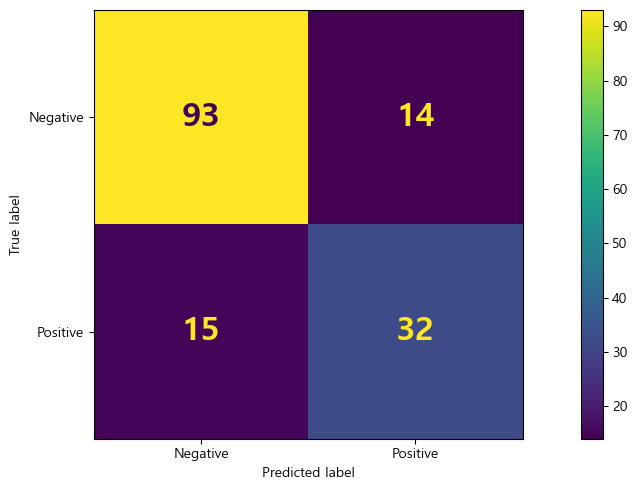

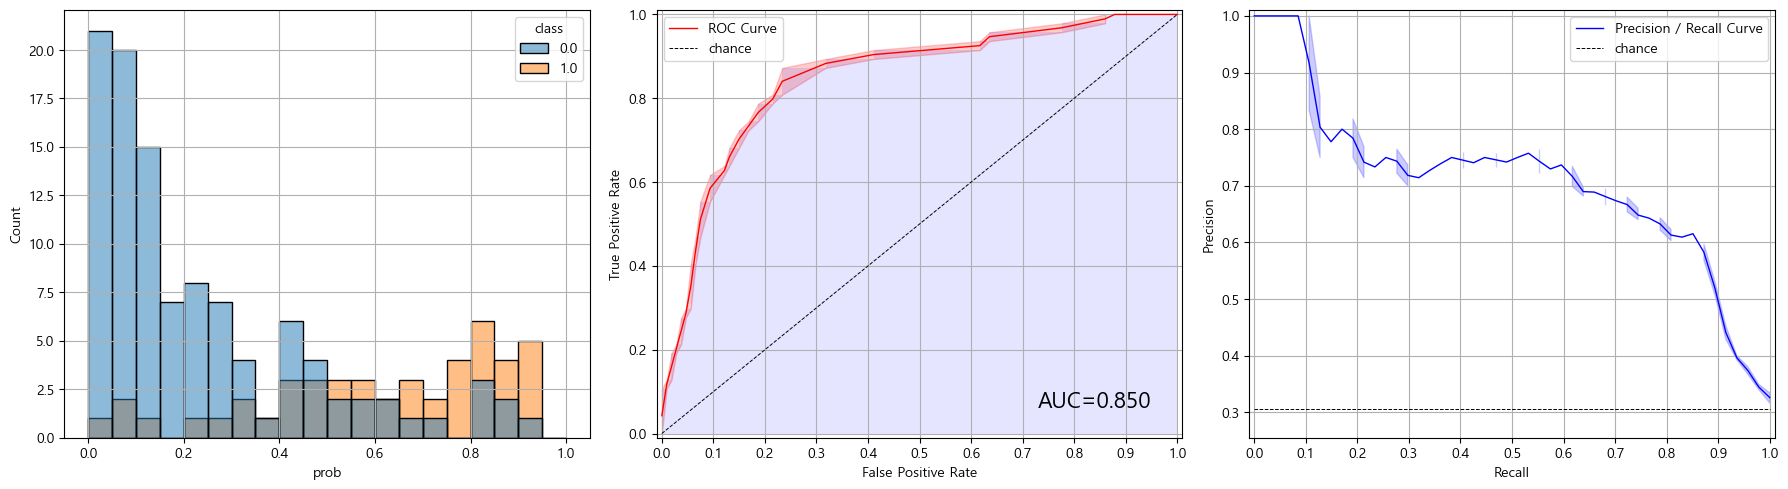


이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.

All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboo

In [4]:
my_classification_result(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

### [3] 학습곡선 직접 도출하기

에러(손실)율에 따른 학습곡선을 손실곡선이라고 함

#### 학습회차별 에러(손실)률 얻기

`fit()` 함수에 `eval_set` 파라미터를 지정해야만 얻을 수 있다.

In [5]:
results = estimator.evals_result()
results

{'validation_0': OrderedDict([('error',
               [0.23127035830618892,
                0.16775244299674266,
                0.14006514657980457,
                0.11237785016286644,
                0.0993485342019544,
                0.08794788273615635,
                0.08306188925081433,
                0.0781758957654723,
                0.07003257328990228,
                0.06514657980456026,
                0.06026058631921824,
                0.05537459283387622,
                0.0488599348534202,
                0.05211726384364821])]),
 'validation_1': OrderedDict([('error',
               [0.2597402597402597,
                0.21428571428571427,
                0.22727272727272727,
                0.2012987012987013,
                0.21428571428571427,
                0.19480519480519481,
                0.2077922077922078,
                0.19480519480519481,
                0.18831168831168832,
                0.2077922077922078,
                0.2012987012987013,

#### 결과값 정리

In [6]:
result_df = DataFrame({
    'train': results['validation_0']['error'],
    'test': results['validation_1']['error'],
})
result_df

,train,test
0,0.231270,0.259740
1,0.167752,0.214286
2,0.140065,0.227273
3,0.112378,0.201299
4,0.099349,0.214286
5,0.087948,0.194805
6,0.083062,0.207792
7,0.078176,0.194805
8,0.070033,0.188312
9,0.065147,0.207792


#### 학습 회차 필드 추가

In [7]:
result_df2 = result_df.reset_index(drop=False, names='epoch')
result_df2['epoch'] += 1
result_df2

,epoch,train,test
0,1,0.231270,0.259740
1,2,0.167752,0.214286
2,3,0.140065,0.227273
3,4,0.112378,0.201299
4,5,0.099349,0.214286
5,6,0.087948,0.194805
6,7,0.083062,0.207792
7,8,0.078176,0.194805
8,9,0.070033,0.188312
9,10,0.065147,0.207792


In [10]:
result_df3 = result_df2.melt(id_vars='epoch', var_name='dataset', value_name='error')
result_df3


,epoch,dataset,error
0,1,train,0.231270
1,2,train,0.167752
2,3,train,0.140065
3,4,train,0.112378
4,5,train,0.099349
5,6,train,0.087948
6,7,train,0.083062
7,8,train,0.078176
8,9,train,0.070033
9,10,train,0.065147


#### 에포크별 손실 그래프

모델 훈련에서 손실은 학습을 거듭할 수록 감소하는 것이 정상

모델이 학습을 반복하면 훈련, 검증 데이터에 대한 에러는 점점 감소하지만 모델이 노이즈를 학습할 경우 곡선 사이에 간격이 생기며 이 간격은 모델이 얼마나 많은 노이즈를 학습했는가를 의미한다.

> 간격이 넓으면 과적합!!!

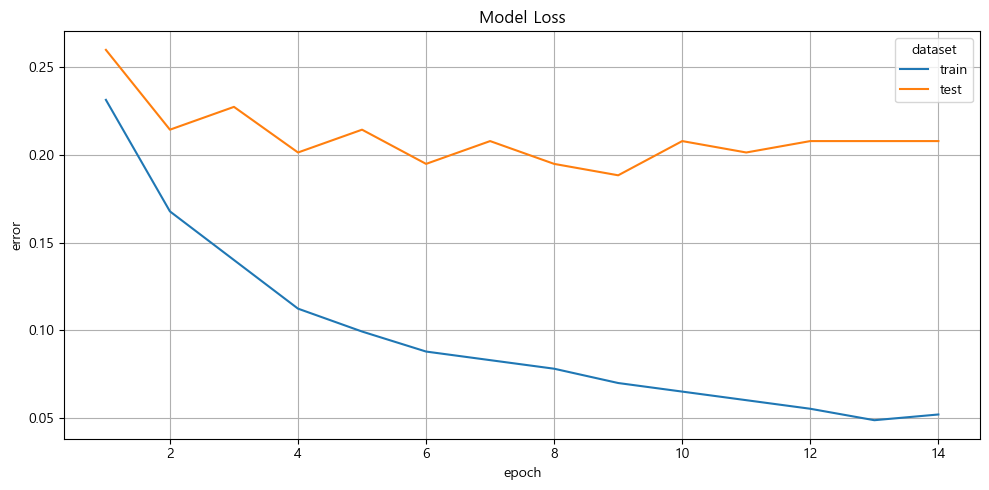

In [11]:
my_lineplot(result_df3, xname='epoch', yname='error', hue='dataset', callback=lambda ax: ax.set_title("Model Loss"))

### [4] 각 변수별 중요도 확인

#### 변수별 중요도 시각화

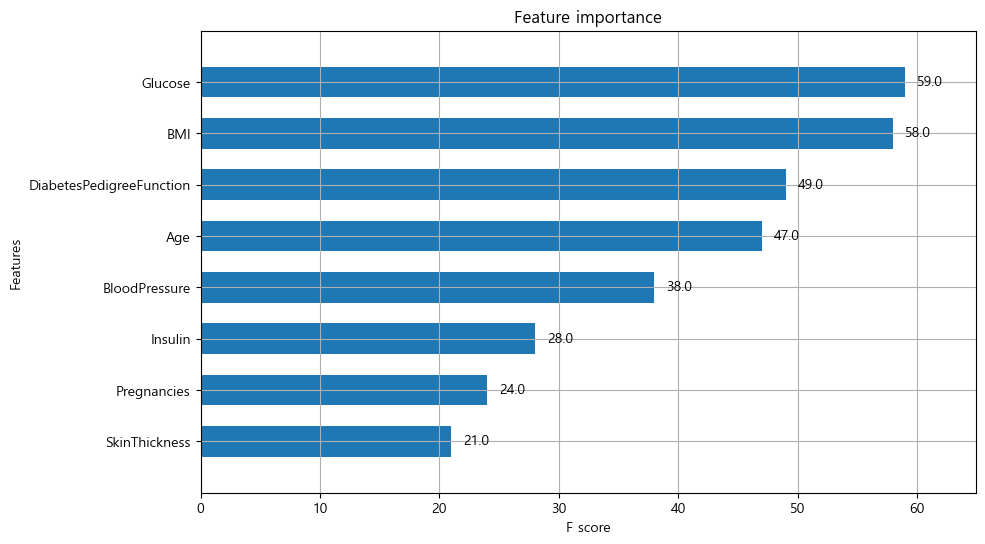

In [12]:
fig = plt.figure(figsize=(10, 6), dpi=100)
ax = fig.gca()
plot_importance(estimator, height=0.6, ax=ax)
plt.show()
plt.close()

#### 변수별 가중치 점수 추출

In [13]:
feature_important = estimator.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data['rate'] = data['score'] / data['score'].sum()
data['cumsum'] = data['rate'].cumsum()

data

,score,rate,cumsum
Glucose,59.0,0.182099,0.182099
BMI,58.0,0.179012,0.361111
DiabetesPedigreeFunction,49.0,0.151235,0.512346
Age,47.0,0.145062,0.657407
BloodPressure,38.0,0.117284,0.774691
Insulin,28.0,0.086420,0.861111
Pregnancies,24.0,0.074074,0.935185
SkinThickness,21.0,0.064815,1.000000


### [5] 분류 과정 트리 확인

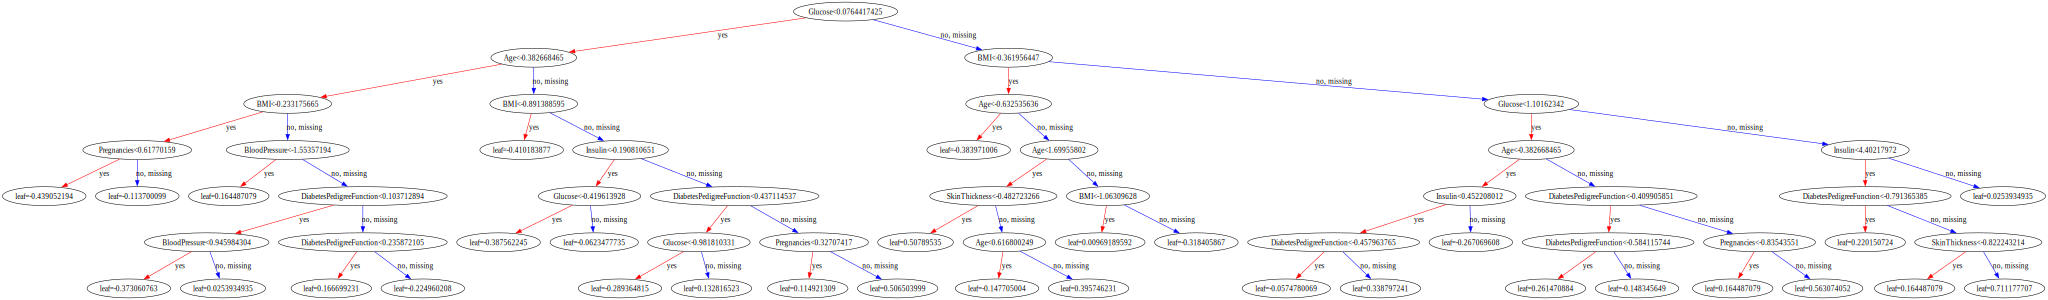

In [14]:
to_graphviz(booster=estimator)